In [587]:
# Libraries
import pandas as pd
from collections import Counter
from functools import reduce
import numpy as np
from ast import literal_eval  # Import literal_eval to safely evaluate string representation of lists
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# Data processing 
import pandas as pd
import numpy as np

# Dataset
from sklearn import datasets

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hier
from sklearn.mixture import GaussianMixture

import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


# 2. Grouping Users together!
Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

## 2.1 Getting your data + feature engineering
Access to the data found in this dataset

Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

a) Favorite genre (i.e., the genre on which the user spent the most time)

b) Average click duration

c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

e) Average time spent a day by the user (considering only the days he logs in)

In [588]:
# Load data
data = pd.read_csv("vodclickstream_uk_movies_03.csv")
not_clean = data

In [589]:
not_clean.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [590]:
# Cleaning data and adding needed columns

# Remove useless column "Unnamed: 0"
data = data.drop("Unnamed: 0", axis=1)

data["genres"] = data["genres"].apply(lambda x: x.split(", "))

data.drop(data[data["duration"] < 0].index, inplace = True)

data["datetime"] = pd.to_datetime(data["datetime"], errors = 'coerce')
data["release_date"] = pd.to_datetime(data["release_date"], errors = 'coerce')

In [591]:
# Show clean_data df
data.head(10)

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Family,...",2004-11-19,a80d6fc2aa,a57c992287
5,2017-01-01 19:21:37,0.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,c5bf4f3f57
6,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32
7,2017-01-01 19:44:38,0.0,Angel of Christmas,"[Comedy, Romance]",2015-11-29,b2f02f2689,892a51dee1
8,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a
9,2017-01-01 20:27:04,0.0,The Book of Life,"[Animation, Adventure, Comedy, Family, Fantasy...",2014-10-17,97183b9136,bf53608c70


Let's start by adding the features requested on the lab

In [592]:
#Favorite genre (i.e., the genre on which the user spent the most time)
def favourite_genere(df):
    df.drop(df[df.duration == 0].index)
    
    # Explode the list of genres into separate rows
    df_expanded = df.explode('genres')

    # Group by 'user_id' and 'genre', summing up the 'time_spent'
    grouped_df = df_expanded.groupby(['user_id', 'genres'])['duration'].sum().reset_index()

    # Find the index of the maximum 'time_spent' for each user
    idx = grouped_df.groupby('user_id')['duration'].idxmax()

    # Create a DataFrame with only the rows corresponding to the maximum 'time_spent' for each user
    favorite_genre_df = grouped_df.loc[idx]

    # Rename columns for clarity
    favorite_genre_df = favorite_genre_df.rename(columns={'genres': 'favorite_genre', 'duration': 'time_spent_on_favorite_genre'})

    # Merge the new DataFrame back to the original DataFrame based on 'user_id'
    df = pd.merge(df, favorite_genre_df[['user_id', 'favorite_genre']], on='user_id', how='left')

    # Display the updated DataFrame
    return(df)

In [593]:
data = favourite_genere(data)

In [594]:
def avg_click_time(df):
    average_click_time_df = df.groupby('user_id')['duration'].mean().reset_index()

    # Rename the columns for clarity
    average_click_time_df = average_click_time_df.rename(columns={'duration': 'average_click_time'})

    # Merge the new DataFrame back to the original DataFrame based on 'user_id'
    df = pd.merge(df, average_click_time_df, on='user_id', how='left')

    # Display the updated DataFrame
    return(df)

In [595]:
data = avg_click_time(data)

In [596]:
def time_day(df):  
    bins = [0, 6, 13, 20, 24]
    labels = ['Night', 'Morning', 'Afternoon', 'Night']

    # Create a new column 'time_of_day'
    df['time_of_day'] = pd.cut(df['datetime'].dt.hour, bins=bins, labels=labels, include_lowest=True, ordered=False)

    time_of_day_summary = df.groupby('time_of_day')['duration'].sum().reset_index()

    # Find the time_of_day with the maximum total duration
    max_time_of_day = time_of_day_summary.loc[time_of_day_summary['duration'].idxmax(), 'time_of_day']

    # Add a new column 'max_time_of_day' to the original DataFrame
    df['max_time_of_day'] = max_time_of_day
    return(df)


In [597]:
data = time_day(data)

In [598]:
def old_movie(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    threshold_date = pd.Timestamp('2010-01-01')
    df['movie_preference'] = df['release_date'].apply(lambda date: 'Old Movie Lover' if date <= threshold_date else 'Recent Content Lover')
    return(df)

In [599]:
data = old_movie(data)

In [600]:
def avg_timespent(df):
    grouped_df = df.groupby(['user_id', 'datetime'])['duration'].sum().reset_index()
    average_duration_per_day = grouped_df.groupby('user_id')['duration'].mean().reset_index()
    average_duration_per_day = average_duration_per_day.rename(columns={'duration': 'average_duration_per_day'})
    df = pd.merge(df, average_duration_per_day, on='user_id', how='left')
    return(df)

In [601]:
data = avg_timespent(data)

In [602]:
data[data["user_id"]=="b15926c011"]

,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_time,time_of_day,max_time_of_day,movie_preference,average_duration_per_day
307113,2018-03-21 20:42:47,2400.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Afternoon,Afternoon,Old Movie Lover,3324.693351
307136,2018-03-21 21:22:47,179456.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Afternoon,Old Movie Lover,3324.693351
307990,2018-03-23 23:15:47,1217.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Afternoon,Old Movie Lover,3324.693351
308011,2018-03-23 23:36:04,1401.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Afternoon,Old Movie Lover,3324.693351
308035,2018-03-23 23:59:25,2635.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Afternoon,Old Movie Lover,3324.693351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
348142,2018-05-14 00:04:10,1444.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Afternoon,Old Movie Lover,3324.693351
348162,2018-05-14 00:28:14,546.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Afternoon,Old Movie Lover,3324.693351
348480,2018-05-15 20:36:56,46.0,Coin Heist,"[Crime, Drama, Romance, Thriller]",2017-01-06,57e2731b38,b15926c011,Comedy,3324.693351,Afternoon,Afternoon,Recent Content Lover,3324.693351
348495,2018-05-15 20:37:42,86.0,Coin Heist,"[Crime, Drama, Romance, Thriller]",2017-01-06,57e2731b38,b15926c011,Comedy,3324.693351,Afternoon,Afternoon,Recent Content Lover,3324.693351


With the help of ChatGPT and our imagination we thouht of 10 other features we could add to the dataset
ChatGPT helped us select the following:
- average number of movies watched on weekdays vs. weekends
- average number of movies watched on holidays vs. non-holidays
- genres diversity
- number of unique shows watched
- zapping percentage
- average number of shows per month
- time since last watch
- ? amount of time spent when movie/serie is released 
- ? amount of times a serie/movie has been rewatched by the same user

In [603]:
#average number of movies watched on weekdays vs. weekends

def week_end(df):
    df['week_end'] = df['datetime'].dt.weekday.map({0: 'weekday', 1: 'weekday', 2: 'weekday', 3: 'weekday', 4: 'weekday', 5: 'weekend', 6: 'weekend'})
    avg_duration_weekorend = df.groupby('week_end')['duration'].mean().reset_index()
    avg_duration_weekorend = avg_duration_weekorend.rename(columns={'duration': 'avg_duration_weekorend'})
    df = pd.merge(df, avg_duration_weekorend, on='week_end', how='left')
    return(df)


In [604]:
data = week_end(data)

In [605]:
def genere_diversity(df):
    unique_genres = df.explode('genres').groupby('user_id')['genres'].nunique().reset_index()
    
    # Calculate a diversity metric (e.g., Shannon entropy) I asked how to do this to ChatGPT
    unique_genres['genre_diversity'] = -1 * unique_genres['genres'] * \
    unique_genres['genres'].apply(lambda x: x / unique_genres['genres'].sum()).apply(lambda x: 0 if pd.isna(x) else x * (np.log(x) if x != 0 else 0))
    unique_genres = unique_genres.rename(columns={'genres': 'unique_genres'})
    df = pd.merge(df, unique_genres[['user_id', 'unique_genres']], on='user_id', how='left')
    df = pd.merge(df, unique_genres[['user_id', 'genre_diversity']], on='user_id', how='left')
    return(df)

In [606]:
data = genere_diversity(data)

In [607]:
# number of unique shows watched

def unique_shows(df):
    unique_movies_count = df.groupby('user_id')['movie_id'].nunique().reset_index()
    # Rename the column for clarity
    unique_movies_count = unique_movies_count.rename(columns={'movie_id': 'unique_movies_count'})
    df = pd.merge(df, unique_movies_count, on='user_id', how='left')
    return(df)

In [608]:
data = unique_shows(data)

In [609]:
def zapping(df):
    df['time_diff'] = df.groupby('user_id')['datetime'].diff()

    time_threshold = pd.Timedelta('5 minutes')

    # Identify zapping events based on the time threshold
    df['zapping_event'] = (df['time_diff'] <= time_threshold) & (df['time_diff'].notna())

    # Calculate the zapping percentage for each user
    zapping_percentage = df.groupby('user_id')['zapping_event'].mean().reset_index()
    zapping_percentage = zapping_percentage.rename(columns={'zapping_event': 'zapping_percentage'})

    # Merge back to the original DataFrame based on 'user_id'
    df = pd.merge(df, zapping_percentage, on='user_id', how='left')
    columns_to_drop = ['zapping_event', 'time_diff']
    df = df.drop(columns=columns_to_drop)
    return(df)


In [610]:
data = zapping(data)

In [611]:
#average number of movies per month
def avg_movies_month(df):
    df['month'] = df['datetime'].dt.to_period('M')

    # Group by user_id and month, then count the number of shows
    average_shows_per_month = df.groupby(['user_id', 'month'])['movie_id'].count().reset_index()

    # Calculate the average number of shows per month per user
    average_shows_per_month = average_shows_per_month.groupby('user_id')['movie_id'].mean().reset_index()
    average_shows_per_month = average_shows_per_month.rename(columns={'movie_id': 'average_movies_per_month'})

    df = pd.merge(df, average_shows_per_month, on='user_id', how='left')
    columns_to_drop = ['month']
    df = df.drop(columns=columns_to_drop)
    return(df)

In [612]:
data = avg_movies_month(data)

In [613]:
#time since last watch 
def last_time(df):
    df = df.sort_values(by=['user_id', 'datetime'])

    # Calculate the time difference between consecutive rows for each user
    df['time_since_last_watch'] = (df.groupby('user_id')['datetime'].diff()  / pd.Timedelta(days=1))
    df['time_since_last_watch'].fillna(0, inplace=True)
    return(df)

In [614]:
data = last_time(data)

In [615]:
#amount of times a movie has been rewathced for each user
def rewatch(df):
    df = df.sort_values(by=['user_id', 'datetime'])

    # Calculate the time difference between consecutive rows for each user and movie/series
    df['time_diff'] = df.groupby(['user_id', 'movie_id'])['datetime'].diff()

    # Filter entries where the time difference is greater than a threshold (e.g., 1 day)
    rewatched_df = df[df['time_diff'] > pd.Timedelta('1 day')]

    # Count the number of times each movie/series has been rewatched by the same user
    rewatch_count = rewatched_df.groupby(['user_id', 'movie_id']).size().reset_index(name='rewatch_count')

    df = pd.merge(df, rewatch_count, on='user_id', how='left')
    return(df)


In [616]:
#rewatch(data)

In [617]:
def calculate_content_diversity_index(df):

    exploded_genres = df.explode('genres')

    # Calculate the number of unique genres each user has watched
    unique_genres_per_user = exploded_genres.groupby('user_id')['genres'].nunique()

    # Calculate the total number of unique genres in the dataset
    total_unique_genres = exploded_genres['genres'].nunique()

    # Normalizing the diversity index
    diversity_index = unique_genres_per_user / total_unique_genres

    # Map the diversity index back to the original DataFrame
    df['content_diversity_index'] = df['user_id'].map(diversity_index)

    return df


data = calculate_content_diversity_index(data)



In [618]:
# Function to assign a season to a date
def assign_season(df):

    df['month'] = df['datetime'].dt.month
    
    conditions = [
    (df['month'] >= 3) & (df['month'] <= 5),
    (df['month'] >= 6) & (df['month'] <= 8),
    (df['month'] >= 9) & (df['month'] <= 11),
    (df['month'] == 12) | (df['month'] <= 2),
    ]

    choices = ['Spring', 'Summer', 'Autumn', 'Winter']


    df['season'] = np.select(conditions, choices, default='Winter')
    
    seasonal_viewing = df.groupby('user_id')['season'].value_counts(normalize=True).unstack(fill_value=0)
    
    favorite_season = seasonal_viewing.idxmax(axis=1)
    
    favorite_season_map = favorite_season.to_dict()
    
    df['favorite_season'] = df['user_id'].map(favorite_season_map)
    
    return df

data = assign_season(data)

In [619]:
data.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_time,time_of_day,...,unique_genres,genre_diversity,unique_movies_count,zapping_percentage,average_movies_per_month,time_since_last_watch,content_diversity_index,month,season,favorite_season
217707,2017-12-05 20:39:15,0.0,Hannibal,"[Crime, Drama, Thriller]",2001-02-09,9bfee795ff,00004e2862,Crime,0.000000,Afternoon,...,3,0.000136,1,0.000000,1.0,0.000000,0.111111,12,Winter,Winter
82016,2017-05-23 18:41:44,2957.0,Frailty,"[Crime, Drama, Thriller]",2002-04-12,7314699c23,000052a0a0,Action,2024.166667,Afternoon,...,14,0.002602,11,0.416667,12.0,0.000000,0.518519,5,Spring,Summer
81597,2017-05-23 19:47:31,1512.0,Frailty,"[Crime, Drama, Thriller]",2002-04-12,7314699c23,000052a0a0,Action,2024.166667,Afternoon,...,14,0.002602,11,0.416667,12.0,0.045683,0.518519,5,Spring,Summer
81795,2017-05-23 21:37:40,1198.0,Frailty,"[Crime, Drama, Thriller]",2002-04-12,7314699c23,000052a0a0,Action,2024.166667,Night,...,14,0.002602,11,0.416667,12.0,0.076493,0.518519,5,Spring,Summer
82416,2017-05-24 07:29:07,0.0,Resident Evil,"[Action, Horror, Sci-Fi]",2002-03-15,6275614f9a,000052a0a0,Action,2024.166667,Morning,...,14,0.002602,11,0.416667,12.0,0.410729,0.518519,5,Spring,Summer


In [620]:
print(data.dtypes)

datetime                    datetime64[ns]
duration                           float64
title                               object
genres                              object
release_date                datetime64[ns]
movie_id                            object
user_id                             object
favorite_genre                      object
average_click_time                 float64
time_of_day                       category
max_time_of_day                     object
movie_preference                    object
average_duration_per_day           float64
week_end                            object
avg_duration_weekorend             float64
unique_genres                        int64
genre_diversity                    float64
unique_movies_count                  int64
zapping_percentage                 float64
average_movies_per_month           float64
time_since_last_watch              float64
content_diversity_index            float64
month                                int32
season     

In [621]:
len(data)

650002

## 2.2

### 1
To normalise or not to normalise? 

In [622]:
numerical_features = data.select_dtypes(['float64','int64']).columns 
numerical_features

Index(['duration', 'average_click_time', 'average_duration_per_day',
       'avg_duration_weekorend', 'unique_genres', 'genre_diversity',
       'unique_movies_count', 'zapping_percentage', 'average_movies_per_month',
       'time_since_last_watch', 'content_diversity_index'],
      dtype='object')

In [623]:
data_norm = data.copy()

In [624]:
#MinMaxScalre takes care of NaN values
scaler = MinMaxScaler()

# Fit and transform the selected continuous features
data_norm[numerical_features] = scaler.fit_transform(data_norm[numerical_features])

<Axes: >

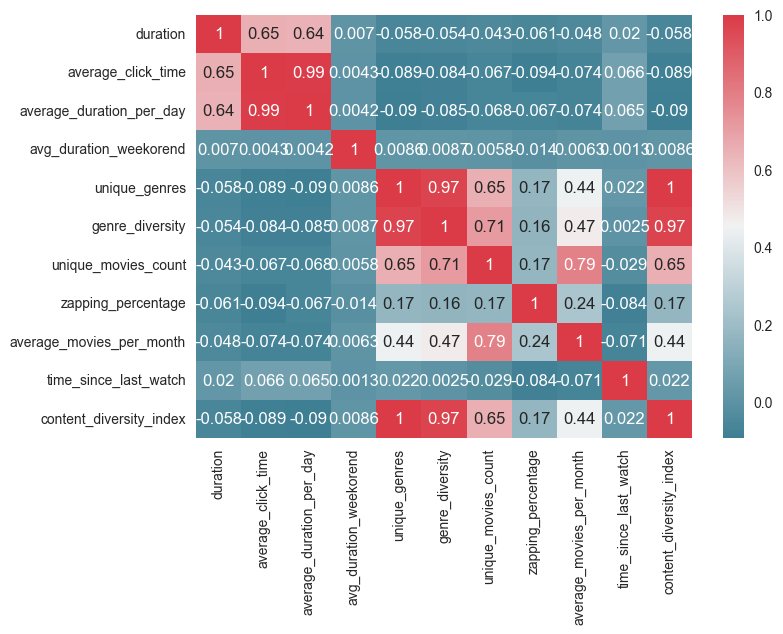

In [625]:
import seaborn as sns
corr = data_norm[numerical_features].corr()
#we are building a heatmap for getting the pairwise correlation between the features:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            annot=True)

keep: average duration per day, genre diversity, zapping percentage, average movies per month, content diversity index

In [626]:
#columns_to_drop=['average_click_time','duration','unique_genres','unique_movies_count']

In [627]:
#data_norm=data_norm.drop(columns=columns_to_drop)

In [628]:
data_norm.select_dtypes(['object','bool']).columns

Index(['title', 'genres', 'movie_id', 'user_id', 'favorite_genre',
       'max_time_of_day', 'movie_preference', 'week_end', 'season',
       'favorite_season'],
      dtype='object')

In [629]:
categorical_features = ['favorite_genre',
        'movie_preference', 'week_end', 
        'favorite_season']

In [630]:
label_encoder = LabelEncoder()

data_norm[categorical_features] = data_norm[categorical_features].apply(label_encoder.fit_transform)

<Axes: >

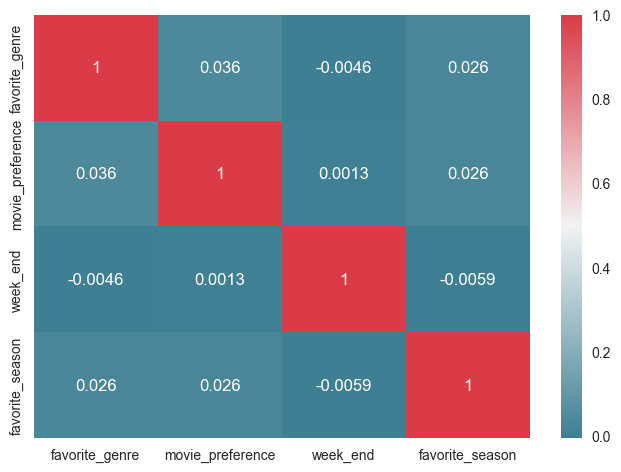

In [631]:
import seaborn as sns
corr = data_norm[categorical_features].corr()
#we are building a heatmap for getting the pairwise correlation between the features:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            annot=True)

keep all

now these are the selected features for the dimentionality reduction:

In [632]:

features = ['user_id','favorite_genre',
'movie_preference', 'week_end', 
'favorite_season', 'average_duration_per_day',
'avg_duration_weekorend',  'genre_diversity',
'zapping_percentage',
'time_since_last_watch']

data_norm_reduced = data_norm[features]
data_norm_reduced

,user_id,favorite_genre,movie_preference,week_end,favorite_season,average_duration_per_day,avg_duration_weekorend,genre_diversity,zapping_percentage,time_since_last_watch
217707,00004e2862,5,0,0,3,0.000000,1.0,0.017905,0.000000,0.000000
82016,000052a0a0,0,0,0,2,0.000235,1.0,0.386537,0.451389,0.000000
81597,000052a0a0,0,0,0,2,0.000235,1.0,0.386537,0.451389,0.000091
81795,000052a0a0,0,0,0,2,0.000235,1.0,0.386537,0.451389,0.000152
82416,000052a0a0,0,0,0,2,0.000235,1.0,0.386537,0.451389,0.000816
...,...,...,...,...,...,...,...,...,...,...
165261,fffeac83be,7,0,0,2,0.003540,1.0,0.164763,0.098485,0.015862
166579,fffeac83be,7,1,0,2,0.003540,1.0,0.164763,0.098485,0.003994
126545,ffff2c5f9e,0,1,1,2,0.000000,0.0,0.051805,0.000000,0.000000
126769,ffff2c5f9e,0,0,1,2,0.000000,0.0,0.051805,0.000000,0.000024


### 2
Dimentionality reduction

In [633]:
data_pca=data_norm_reduced.loc[:,data_norm_reduced.columns != 'user_id']
# Standardize the data (important for PCA): PCA must be applied on features in the same scale
scaler = StandardScaler()
data_pca = scaler.fit_transform(data_pca)
# Applying PCA to the features
pca = PCA() #not specifying any number of components and applying to get the projection of all features
pca_components = pca.fit_transform(data_pca)

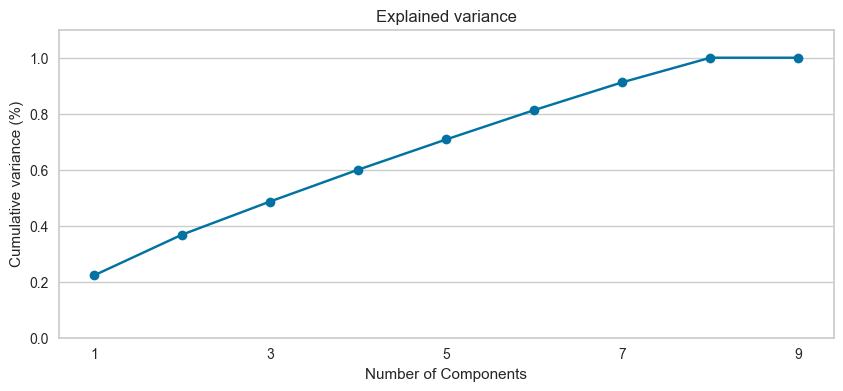

In [634]:
# Explained variance (how important each additional principal component is)
pca = PCA().fit(data_pca)
fig, ax = plt.subplots(figsize=(10,4))
xi = np.arange(1, 1+data_pca.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+data_pca.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance')
ax.grid(axis='x')

good number of features could be when the variance explained is 80%

In [635]:
# Calculating the cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Determining the number of components to keep for 85% variance explained
n_components = np.argmax(cumulative_variance_ratio >= 0.80) + 1
n_components

6

In [636]:
pca = PCA(n_components=n_components)
data_reduced = pca.fit_transform(data_pca)

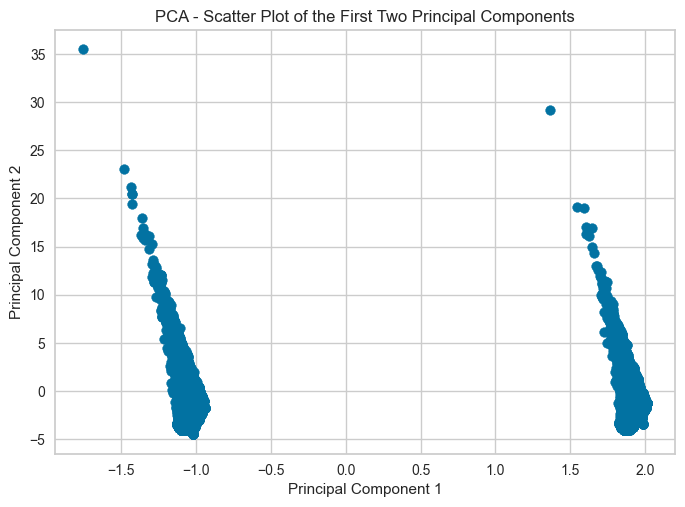

In [637]:
plt.scatter(data_reduced[:, 0], data_reduced[:, 1])
plt.title('PCA - Scatter Plot of the First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

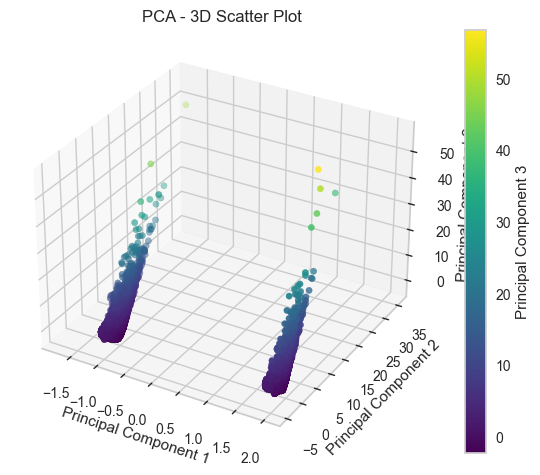

In [638]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming data_reduced is a 2D array from PCA
# and third_dimension is a 1D array with values for the third dimension
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_reduced[:, 0], data_reduced[:, 1],data_reduced[:, 2] , c=data_reduced[:, 2], cmap='viridis')

ax.set_title('PCA - 3D Scatter Plot')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding a colorbar
cbar = fig.colorbar(scatter, ax=ax, label='Principal Component 3')

plt.show()


In [639]:
#converting the PCA reduced data to a pandas dataframe.
data_final=pd.DataFrame(data_reduced)

#We want the User ID to still be the primary key for our projected data 

data_final.index = data_norm_reduced['user_id']
data_final

,0,1,2,3,4,5
user_id,,,,,,
00004e2862,-1.064877,0.753428,-0.866503,0.123785,1.919903,-0.034630
000052a0a0,-1.029460,-1.261692,-1.352614,1.049361,1.417281,0.228883
000052a0a0,-1.029491,-1.259815,-1.347471,1.052320,1.418332,0.224368
000052a0a0,-1.029512,-1.258549,-1.344003,1.054316,1.419041,0.221323
000052a0a0,-1.029740,-1.244813,-1.306380,1.075964,1.426732,0.188290
...,...,...,...,...,...,...
fffeac83be,-1.066761,0.460085,0.305430,1.408300,1.394456,-0.303175
fffeac83be,-1.058716,0.133163,0.433702,-0.597091,-0.045892,-0.166141
ffff2c5f9e,1.905078,1.103996,-0.568926,-1.025393,0.067822,-0.596071


## 2.3


### 1

**Outline of the code**

1. Initialize random centroids
2. Get labels for each data point (Map)
3. Create new centroids (Reduce)
4. Plot the centroids
5. Repeat 3-5 until the centroids stop changing


In [640]:

def assign_centroid(centroids,p):
    distances = [np.linalg.norm(p - centroid) for centroid in centroids]
    closest_centroid = np.argmin(distances)
    return closest_centroid

def map_(data, centroids):
    cluster_assignments = []
    for point in data:
        cluster_assignments.append((assign_centroid(centroids, point), point))
    return cluster_assignments

def reduce_(cluster_assignments, k):
    cluster_assignments = np.array(cluster_assignments, dtype=object)
    new_centroids = [np.mean(cluster_assignments[cluster_assignments[:, 0] == i][:, 1], axis=0) for i in range(k)]
    return new_centroids

def plot_clusters(data,centroids,cluster_assignments, k, i):
    # In order to visualize the clustering process we use PCA once again to make a 2-dimentional plot
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids)
    cluster_ids, clustered_data = zip(*cluster_assignments)
    
    # Plot the clustered data
    clear_output(wait=True)
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_ids, cmap='viridis', alpha=0.7)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=100, c='red')
    plt.title(f'Iteration (i={i})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    
# K-means algorithm
def Kmeans_from_scratch_with_plot_mapreduce(data, k, max_iterations=100):
    
    # Step 1: Initialize centroids randomly
    centroids = data[np.random.choice(len(data), k, replace=False)]

    for i in range(max_iterations):
        # Step 2: Get labels for each data point (Map)
        cluster_assignments = map_(data, centroids)
        
        # Step 3: Create new centroids (Reduce)
        new_centroids = reduce_(cluster_assignments, k)
        
        # Step 5: Repeat 3-5 until the centroids stop changing
        if np.all(np.array(new_centroids) == np.array(centroids)):
            # Step 4: Plot the centroids
            plot_clusters(data,centroids,cluster_assignments, k, i)
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    return centroids

### 2


Find an optimal number of clusters.

#### Method 1: Elbow

The elbow method is the most widely used method for choosing the number of clusters. It runs clustering models for a range of cluster numbers and plots the within cluster sum of squares. The elbow on the plot shows the point where the diminishing returns for additional clusters happen.

In [641]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

C:\Users\Gabriele\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

C:\Users\Gabriele\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



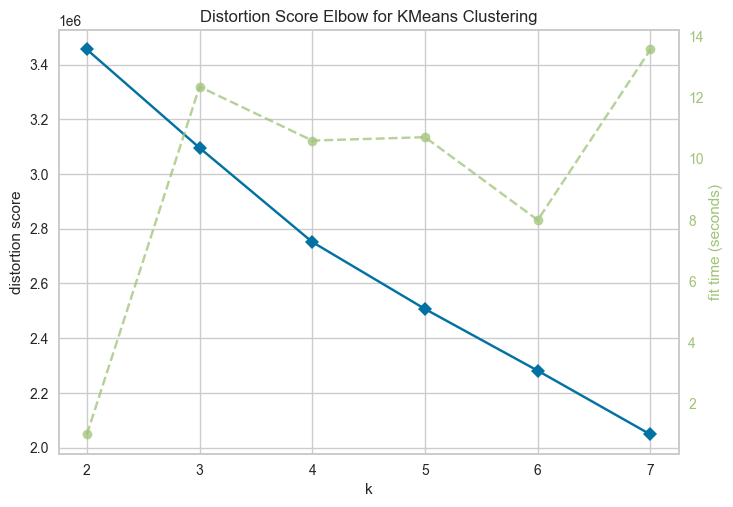

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [642]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,8))

visualizer.fit(data_reduced)
visualizer.show()

##### Method 2: Silhouette method

In [643]:
#We took a sample of 10,000 items from our dataset
data_sample = data_final.sample(10000)

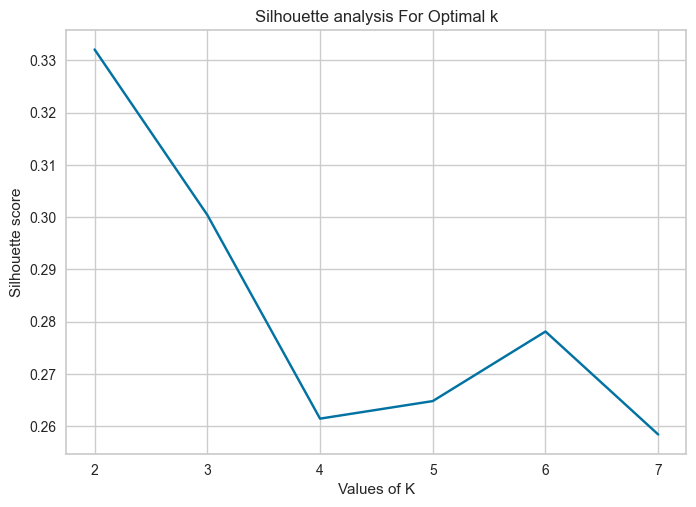

In [644]:
clusters = [2, 3, 4, 5, 6, 7]
silhouette_avg = []

for cluster in clusters:
    kmeans=KMeans(n_clusters=cluster, random_state=42).fit(data_sample)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(data_sample, cluster_labels))
    
plt.plot(clusters,silhouette_avg,'bx-')    
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

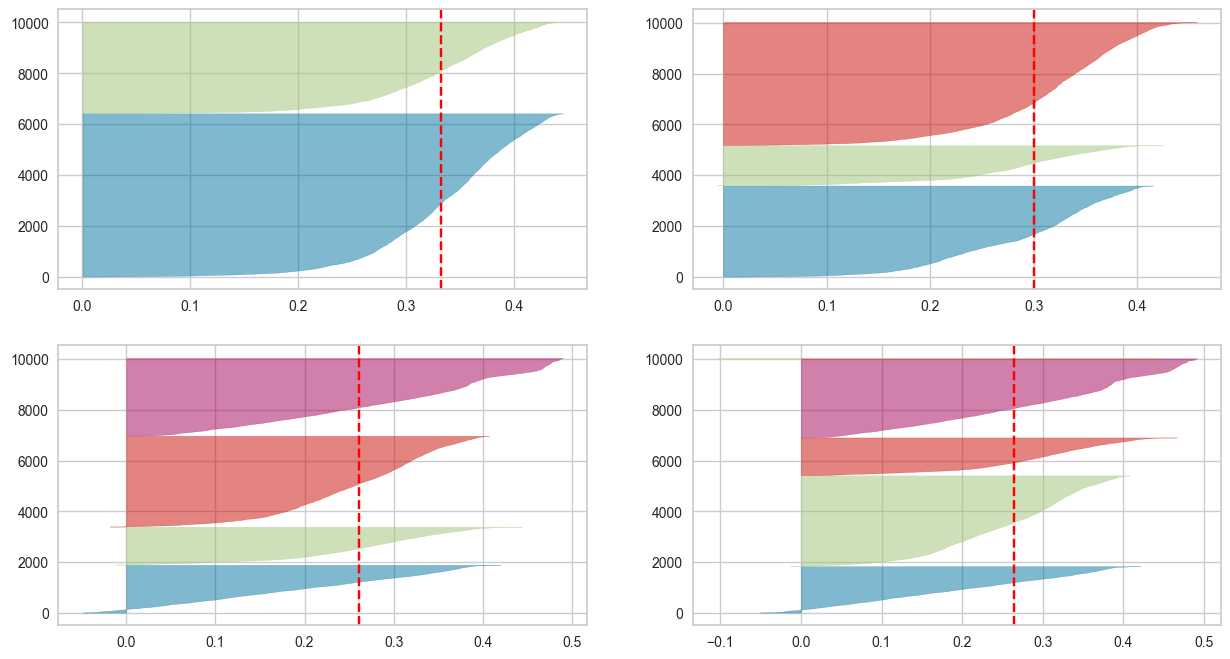

In [645]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_sample)
    cluster_labels = km.fit_predict(data_sample)
    silhouette_avg = silhouette_score(data_sample, cluster_labels)

#### Method 3: Hierarchical Graph

The y axis is the euclidean distance, so the longer the vertical line is, the larger distance between the clusters.

From the graph, we can see that the two clusters connected by the blue line have the largest distance, and the two sub-clusters in red have a relatively large distance too. Therefore, the hierarchical graph suggests 2 or 3 clusters as well.

Text(0, 0.5, 'Euclidean Distance')

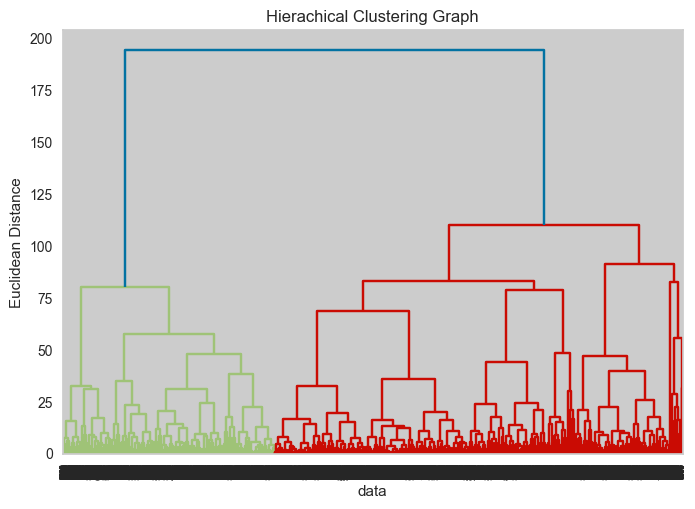

In [646]:
# Change figure size
#plt.figure(figsize=(16,12))
plt.figure()

# Fit the heirachical graph
heirachical_graph=hier.dendrogram(hier.linkage(data_sample, method='ward')) #method='ward' uses the Ward variance minimization algorithm

# Add titles and labels
plt.title('Hierachical Clustering Graph')
plt.xlabel('data')
plt.ylabel('Euclidean Distance')

### 3

Run the algorithm on the data obtained from the dimensionality reduction.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


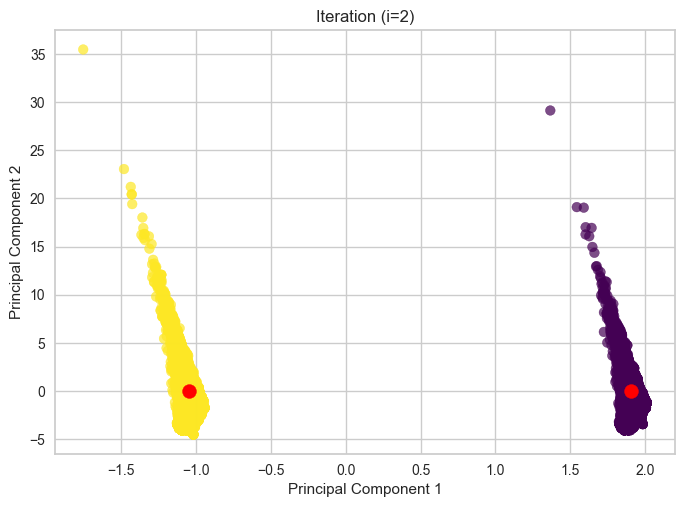

In [647]:
optimal_k=2
final_centroids = Kmeans_from_scratch_with_plot_mapreduce(data_reduced, optimal_k)

### 4

Implement K-means++ from scratch and explain the differences with the results you got earlier.

In [648]:
def kmeans_plusplus_init(data, k):
    # Choose the first centroid randomly from the data points
    centroids = [data[np.random.choice(data.shape[0])]]
    #centroids = data[np.random.choice(len(data), 1, replace=False)]
    # Choose the remaining centroids using K-means++ method
    for _ in range(1, k):
        # Calculate distances from each data point to the nearest existing centroid
        distances = np.array([min(np.linalg.norm(point - np.array(centroid)) for centroid in centroids) for point in data])

        # Calculate probabilities for each data point based on squared distances
        probabilities = distances**2 / np.sum(distances**2)

        # Choose the next centroid randomly from the data points based on probabilities
        new_centroid = data[np.random.choice(data.shape[0], p=probabilities)]
        centroids.append(new_centroid)

    return np.array(centroids)

This implementation randomly selects the first centroid and then chooses the subsequent centroids with a probability proportional to the squared distance from the nearest existing centroid. This ensures that the initial centroids are well spread out in the data space.

K-means++ is typically used as the initialization step to provide better starting points for convergence.

In [651]:
# K-means++ algorithm
def Kmeans_pp_from_scratch_with_plot_mapreduce(data, k, max_iterations=100):
    # Step 1: Initialize centroids with the new method (++)
    centroids = kmeans_plusplus_init(data, k)

    for i in range(max_iterations):
        # Step 2: Get labels for each data point (Map)
        cluster_assignments = map_(data, centroids)
        
        # Step 3: Create new centroids (Reduce)
        new_centroids = reduce_(cluster_assignments, k)
                
        # Step 5: Repeat 3-5 until the centroids stop changing
        if np.all(np.array(new_centroids) == np.array(centroids)):
            # Step 4: Plot the centroids
            plot_clusters(data,centroids,cluster_assignments, k, i)
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    return centroids

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


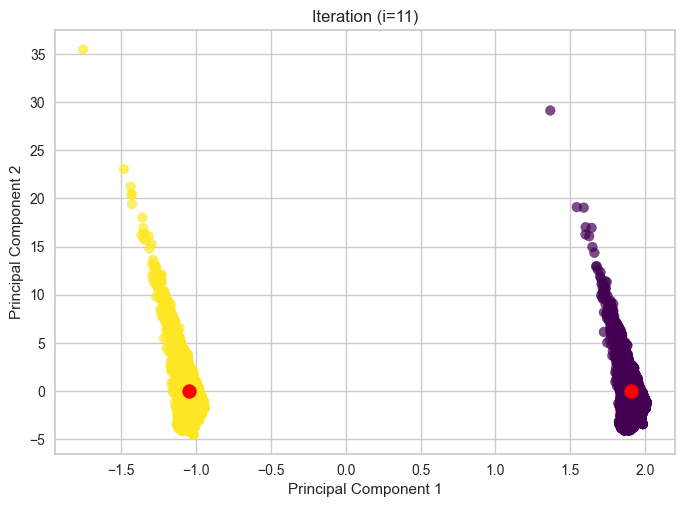

In [652]:
final_centroids = Kmeans_pp_from_scratch_with_plot_mapreduce(data_reduced, optimal_k)

### 5

Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

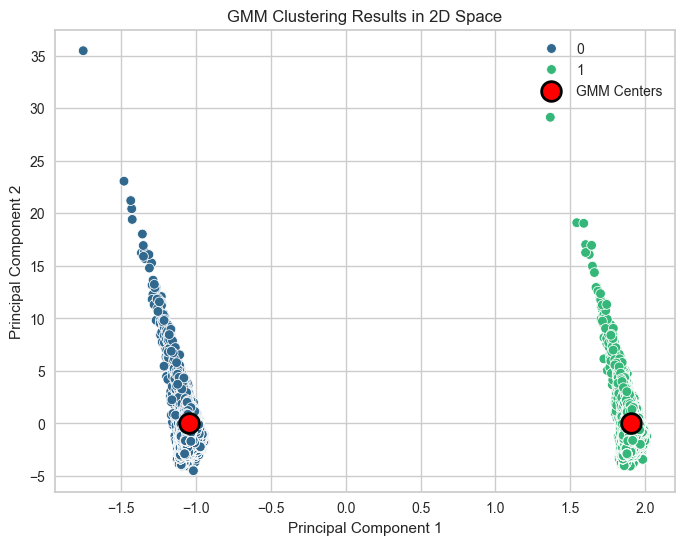

In [653]:
from sklearn.mixture import GaussianMixture

# Create a Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_k)

# Fit the GMM to the reduced data
gmm.fit(data_reduced)

# Predict the cluster labels for each data point
cluster_labels = gmm.predict(data_reduced)

# You can also obtain the probabilities of each sample belonging to each cluster
# This can be useful for assessing the uncertainty of the clustering
probs = gmm.predict_proba(data_reduced)

# Now, cluster_labels contains the cluster assignments for each data point
# probs contains the probability scores for each data point in each cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_reduced[:, 0], y=data_reduced[:, 1], hue=cluster_labels, palette='viridis', legend='full')

# Plot the GMM cluster centers
means = gmm.means_
plt.scatter(means[:, 0], means[:, 1], marker='o', s=200, c='red', edgecolors='black', linewidths=2, label='GMM Centers')

plt.title('GMM Clustering Results in 2D Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## 2.4

In [654]:
kmeans = KMeans(init="random", n_clusters=optimal_k)

#fit k-means algorithm to data
kmeans.fit(data_pca)

#view cluster assignments for each observation
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [655]:
#Create an empty column to add to the dataframe
data_norm_reduced['Cluster'] = data_norm_reduced.apply(lambda _: '', axis=1)
data_norm_reduced.head()

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_9524\3896161943.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,favorite_genre,movie_preference,week_end,favorite_season,average_duration_per_day,avg_duration_weekorend,genre_diversity,zapping_percentage,time_since_last_watch,Cluster
217707,00004e2862,5,0,0,3,0.000000,1.0,0.017905,0.000000,0.000000,
82016,000052a0a0,0,0,0,2,0.000235,1.0,0.386537,0.451389,0.000000,
81597,000052a0a0,0,0,0,2,0.000235,1.0,0.386537,0.451389,0.000091,
81795,000052a0a0,0,0,0,2,0.000235,1.0,0.386537,0.451389,0.000152,
82416,000052a0a0,0,0,0,2,0.000235,1.0,0.386537,0.451389,0.000816,


In [656]:
#Fill the column with the corresponding cluster for each customer
data_norm_reduced['Cluster'] = kmeans.labels_+1

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_9524\833233282.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [657]:
data_norm_reduced['Cluster'].head()

217707    1
82016     1
81597     1
81795     1
82416     1
Name: Cluster, dtype: int32

In [658]:
#Counting how many customers are in each cluster
c1 = 0
c2 = 0
for i in data_norm_reduced['Cluster']:
  if i == 1:
    c1 += 1
  if i == 2:
    c2 += 1
print( c1, c2)
print(c1+c2)

419286 230716
650002


In [659]:
data_norm_reduced.columns

Index(['user_id', 'favorite_genre', 'movie_preference', 'week_end',
       'favorite_season', 'average_duration_per_day', 'avg_duration_weekorend',
       'genre_diversity', 'zapping_percentage', 'time_since_last_watch',
       'Cluster'],
      dtype='object')

#### 2.4.1 Select 2-3 variables you think are relevant to identify the cluster of the customer. 

In [661]:
#Select variables we think are important to identify a cluster
data1 = pd.DataFrame(data_norm_reduced, columns=['genre_diversity', 'average_duration_per_day', 'zapping_percentage', 'Cluster'])
data1.head()

,genre_diversity,average_duration_per_day,zapping_percentage,Cluster
217707,0.017905,0.000000,0.000000,1
82016,0.386537,0.000235,0.451389,1
81597,0.386537,0.000235,0.451389,1
81795,0.386537,0.000235,0.451389,1
82416,0.386537,0.000235,0.451389,1


#### 2.4.2 Most of your selected variables will be numerical (continuous or discrete), then categorise them into four categories.

In [662]:
#Add a column with the respective category for each numerical variable 
data1['Categories_genre_diversity'] = pd.qcut(data1['genre_diversity'], [0,0.25,0.5,0.75,1], labels=False) +1
data1['Categories_average_duration_per_day'] = pd.qcut(data1['average_duration_per_day'], [0,0.25,0.5,0.75,1], labels=False) +1
data1['Categories_zapping_percentage'] = pd.qcut(data1['zapping_percentage'], [0,0.25,0.5,0.75,1], labels=False,duplicates='drop') +1

In [663]:
data1['Categories_genre_diversity'].head()

217707    1
82016     4
81597     4
81795     4
82416     4
Name: Categories_genre_diversity, dtype: int64

In [664]:
data1['Categories_average_duration_per_day'].head()

217707    1
82016     2
81597     2
81795     2
82416     2
Name: Categories_average_duration_per_day, dtype: int64

In [665]:
data1['Categories_zapping_percentage'].head()

217707    1
82016     3
81597     3
81795     3
82416     3
Name: Categories_zapping_percentage, dtype: int64

In [666]:
data1.head()

,genre_diversity,average_duration_per_day,zapping_percentage,Cluster,Categories_genre_diversity,Categories_average_duration_per_day,Categories_zapping_percentage
217707,0.017905,0.000000,0.000000,1,1,1,1
82016,0.386537,0.000235,0.451389,1,4,2,3
81597,0.386537,0.000235,0.451389,1,4,2,3
81795,0.386537,0.000235,0.451389,1,4,2,3
82416,0.386537,0.000235,0.451389,1,4,2,3


#### 2.4.3 With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

In [667]:
#Pivot table for Average balance divided into 4 categories based on quantiles 
data1.pivot_table('genre_diversity', ['Cluster'], ['Categories_genre_diversity'], aggfunc={'Categories_genre_diversity':'count'})

Categories_genre_diversity,1,2,3,4
Cluster,,,,
1,116339,95479,114259,93209
2,65509,53043,62519,49645


In [668]:
#Pivot table for Average of transactions divided into 4 categories based on quantiles 
data1.pivot_table('average_duration_per_day', ['Cluster'], ['Categories_average_duration_per_day'],aggfunc={'Categories_average_duration_per_day':'count'})

Categories_average_duration_per_day,1,2,3,4
Cluster,,,,
1,102911,103626,106189,106560
2,59592,58875,56322,55927


In [669]:
#Pivot table for Utilisation divided into 4 categories based on quantiles 
data1.pivot_table('zapping_percentage', ['Cluster'], ['Categories_zapping_percentage'], aggfunc={'Categories_zapping_percentage':'count'})

Categories_zapping_percentage,1,2,3
Cluster,,,
1,211438,109152,98696
2,113818,59461,57437


#### 2.4.4 Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.

In [670]:
#Pivot table for Average balance divided into 4 categories based on quantiles 
table=data1.pivot_table('genre_diversity', ['Cluster'], ['Categories_genre_diversity'], aggfunc={'Categories_genre_diversity':'count'})
# Calculate percentages
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table_percentage

Categories_genre_diversity,1,2,3,4
Cluster,,,,
1,27.746932,22.771807,27.250850,22.230411
2,28.393783,22.990603,27.097817,21.517797


In [671]:
#Pivot table for Average of transactions divided into 4 categories based on quantiles 
table=data1.pivot_table('average_duration_per_day', ['Cluster'], ['Categories_average_duration_per_day'],aggfunc={'Categories_average_duration_per_day':'count'})
# Calculate percentages
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table_percentage

Categories_average_duration_per_day,1,2,3,4
Cluster,,,,
1,24.544344,24.714872,25.326150,25.414633
2,25.829158,25.518386,24.411831,24.240625


In [672]:
#Pivot table for Average balance divided into 4 categories based on quantiles (values are in percentage format)
table=data1.pivot_table('zapping_percentage', ['Cluster'], ['Categories_zapping_percentage'], aggfunc={'Categories_zapping_percentage':'count'})
# Calculate percentages
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table_percentage

Categories_zapping_percentage,1,2,3
Cluster,,,
1,50.428109,26.032827,23.539064
2,49.332513,25.772378,24.895109


#### 2.4.5 Interpret the results for each pivot table.

Each value in the pivot table represents the percentage of each category of a variable in the cluster of the corresponding row. For example, in the last pivot table, 26.84% is the percentage of values of the variable 'average_click_time' which are in the third category (in our case between the second and third quartile beacuse we splitted the column values based on the quartiles) and in the fourth cluster. As we can easily calculate the sum of each row is 100 which means that every element of each cluster belongs to a category.

#### 2.4.6 Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?).

The silhouette Coefficient is the most popular evaluation metrics for clustering algorithms. The formula is the following one: $$s = \frac{b-a}{max(b-a)}$$ <br> where **a** is the mean distance between a sample and all other points in the same cluster while **b** is the mean distance between a sample and all other points in the next nearest cluster. <br> The score is bounded between $[-1, 1]$ where -1 means incorrect clustering and 1 means highly dense and wellseparated clusters. 0 means overlapping clusters. 

In [673]:
from sklearn.metrics import silhouette_score

In [674]:
silhouette_score(data_pca, kmeans.labels_, metric='euclidean',sample_size=100000)

0.2742477015529062

To evaluate the clustering we obtained, we used the silhouette score but given the dimensions of the data matrix we had to take just a sample (with size = 100000) to make it run in reasonable time. The result is encouraging, it is bigger than zero which means our clustering goes in the right direction but there might be a little overlapping.